# Installing Libraries and Packages

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import kagglehub
import os
import pickle
import catboost as cb

# Dataset Loading

In [ ]:
# Get path from Kaggle dataset
path = kagglehub.dataset_download("thedevastator/imdb-movie-ratings-dataset")

print("Path to dataset files:", path)

100%|██████████| 312k/312k [00:00<00:00, 12.5MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/thedevastator/imdb-movie-ratings-dataset/versions/2


In [ ]:
# Get directory to see file names
dataset_dir = '/root/.cache/kagglehub/datasets/thedevastator/imdb-movie-ratings-dataset/versions/2'

print(os.listdir(dataset_dir))

['movie_data.csv']


In [ ]:
# Load dataset
file_path = os.path.join(dataset_dir, 'movie_data.csv')
df = pd.read_csv(file_path)
df.head()

,index,director_name,duration,actor_2_name,genres,actor_1_name,movie_title,num_voted_users,actor_3_name,movie_imdb_link,num_user_for_reviews,language,country,title_year,imdb_score
0,0,James Cameron,178.0,Joel David Moore,Action|Adventure|Fantasy|Sci-Fi,CCH Pounder,Avatar,886204,Wes Studi,http://www.imdb.com/title/tt0499549/?ref_=fn_t...,3054.0,English,USA,2009.0,7.9
1,1,Gore Verbinski,169.0,Orlando Bloom,Action|Adventure|Fantasy,Johnny Depp,Pirates of the Caribbean: At World's End,471220,Jack Davenport,http://www.imdb.com/title/tt0449088/?ref_=fn_t...,1238.0,English,USA,2007.0,7.1
2,2,Sam Mendes,148.0,Rory Kinnear,Action|Adventure|Thriller,Christoph Waltz,Spectre,275868,Stephanie Sigman,http://www.imdb.com/title/tt2379713/?ref_=fn_t...,994.0,English,UK,2015.0,6.8
3,3,Christopher Nolan,164.0,Christian Bale,Action|Thriller,Tom Hardy,The Dark Knight Rises,1144337,Joseph Gordon-Levitt,http://www.imdb.com/title/tt1345836/?ref_=fn_t...,2701.0,English,USA,2012.0,8.5
4,4,Doug Walker,NaN,Rob Walker,Documentary,Doug Walker,Star Wars: Episode VII - The Force Awakens ...,8,NaN,http://www.imdb.com/title/tt5289954/?ref_=fn_t...,NaN,NaN,NaN,NaN,7.1


In [ ]:
# Display basic dataset information
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   index                 5043 non-null   int64  
 1   director_name         4939 non-null   object 
 2   duration              5028 non-null   float64
 3   actor_2_name          5030 non-null   object 
 4   genres                5043 non-null   object 
 5   actor_1_name          5036 non-null   object 
 6   movie_title           5043 non-null   object 
 7   num_voted_users       5043 non-null   int64  
 8   actor_3_name          5020 non-null   object 
 9   movie_imdb_link       5043 non-null   object 
 10  num_user_for_reviews  5022 non-null   float64
 11  language              5029 non-null   object 
 12  country               5038 non-null   object 
 13  title_year            4935 non-null   float64
 14  imdb_score            5043 non-null   float64
dtypes: float64(4), int64(

# EDA

In [ ]:
# Handle missing values: replace missing names with "Unknown"
df.fillna({"director_name": "Unknown", "actor_1_name": "Unknown", "actor_2_name": "Unknown", "actor_3_name": "Unknown"}, inplace=True)

# Handle missing numeric values with mean
df.fillna(df.mean(numeric_only=True), inplace=True)

# Feature selection: drop unnecessary columns
df.drop(columns=['movie_title', 'index', 'movie_imdb_link'], inplace=True, errors='ignore')

# Encode categorical variables
categorical_features = ['director_name', 'actor_1_name', 'actor_2_name', 'actor_3_name', 'genres', 'language', 'country']

label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Save Label Encoders for Prediction
with open("label_encoders.pkl", "wb") as f:
    pickle.dump(label_encoders, f)

# Split dataset into train and test sets
features = ["director_name", "duration", "actor_1_name", "actor_2_name", "actor_3_name", "genres",
            "num_voted_users", "num_user_for_reviews", "language", "country", "title_year"]
target = "imdb_score"

X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42)

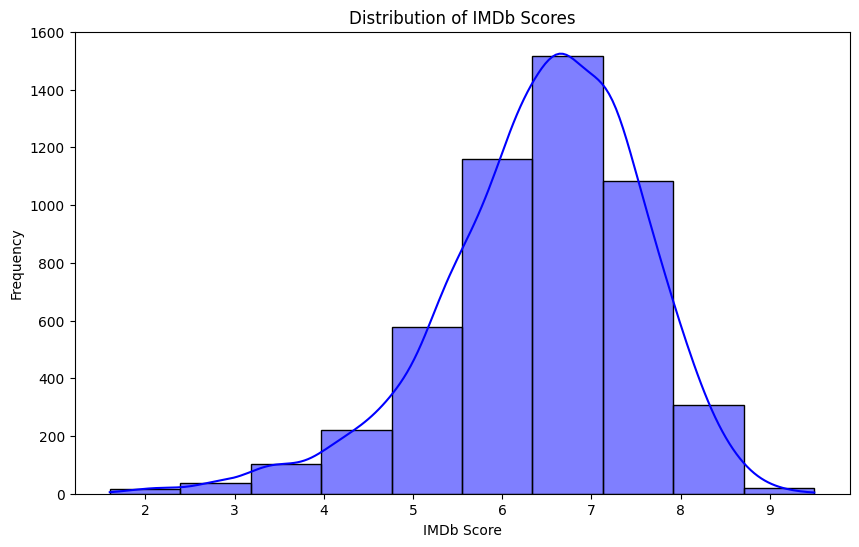

In [ ]:
X = df[['director_name', 'duration', 'actor_1_name', 'actor_2_name', 'actor_3_name', 'genres', 'num_voted_users', 'num_user_for_reviews', 'language', 'country', 'title_year']]
y = df['imdb_score']

# Distribution of IMDb scores
plt.figure(figsize=(10, 6))
sns.histplot(y, bins=10, kde=True, color='blue')
plt.title('Distribution of IMDb Scores')
plt.xlabel('IMDb Score')
plt.ylabel('Frequency')
plt.show()

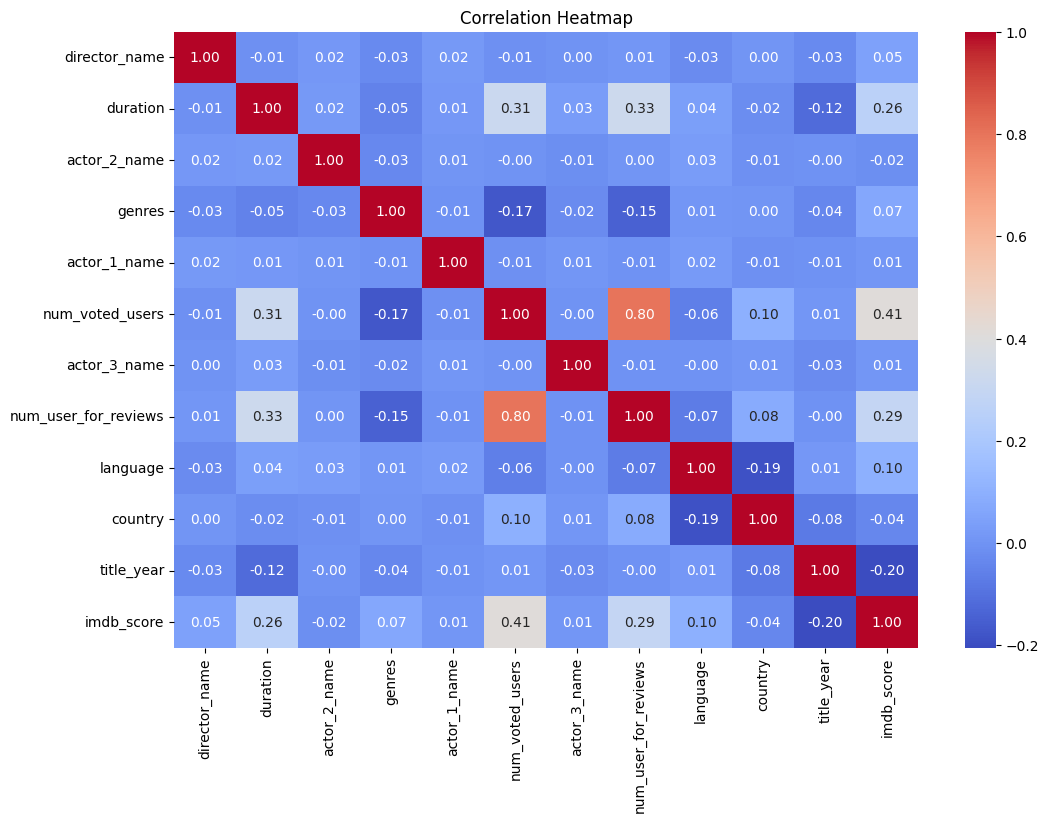

In [ ]:
# Correlation heatmap
plt.figure(figsize=(12, 8))
numeric_df = df.select_dtypes(include=[np.number])
corr = numeric_df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

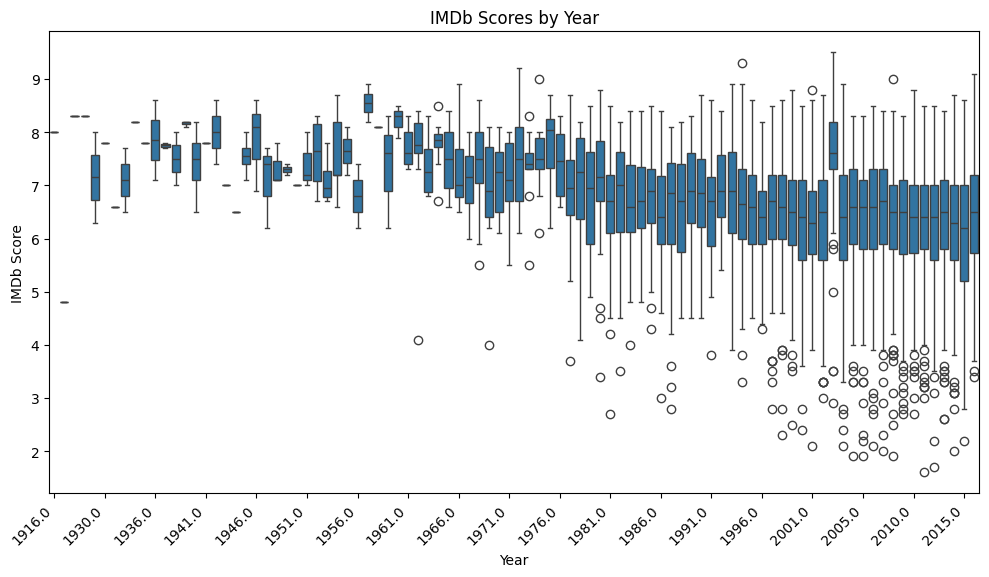

In [ ]:
# IMDB scores by year
plt.figure(figsize=(12, 6))
ax = sns.boxplot(x='title_year', y='imdb_score', data=df)
ax.set_xticks(ax.get_xticks()[::5])
plt.xticks(rotation=45, ha='right')
plt.title('IMDb Scores by Year')
plt.xlabel('Year')
plt.ylabel('IMDb Score')
plt.show()

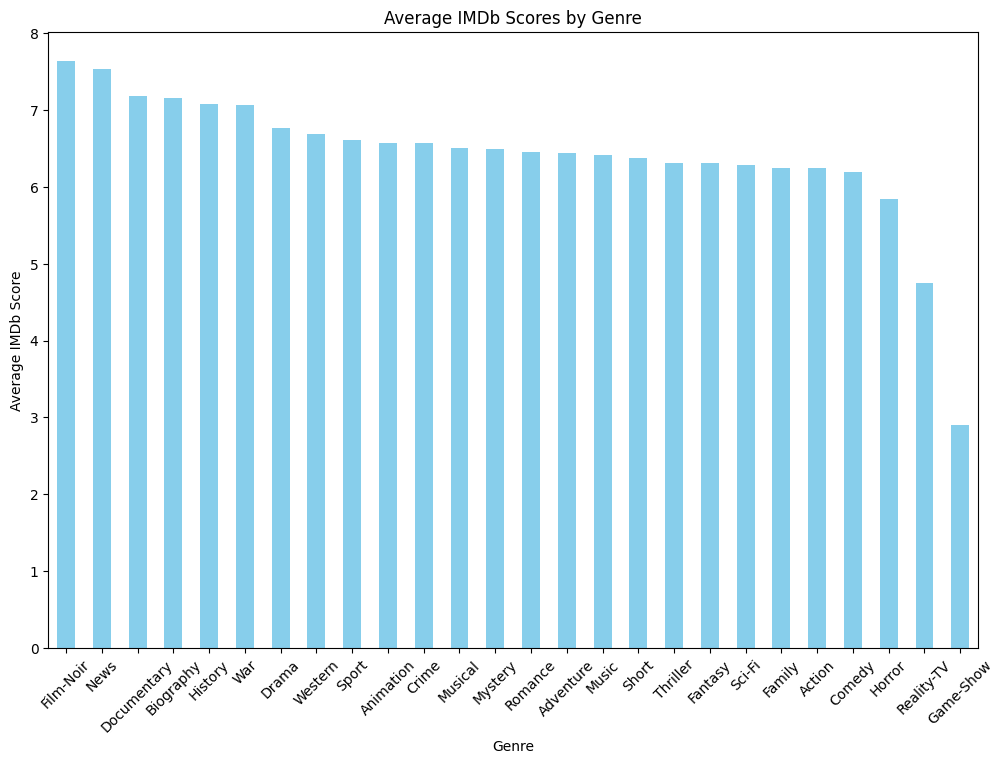

In [ ]:
# Impact of genres on IMDb scores
genre = pd.read_csv(file_path)
genre['genres'] = genre['genres'].astype(str).fillna('Unknown')

# Split the genres column into individual genres (since a movie can have multiple genres)
genre['genres'] = genre['genres'].str.split('|')
genre = genre.explode('genres')

# Calculate the average IMDb score for each genre
genre_avg_scores = genre.groupby('genres')['imdb_score'].mean().sort_values(ascending=False)

# Plot the average IMDb scores by genre
plt.figure(figsize=(12, 8))
genre_avg_scores.plot(kind='bar', color='skyblue')
plt.title('Average IMDb Scores by Genre')
plt.xlabel('Genre')
plt.ylabel('Average IMDb Score')
plt.xticks(rotation=45)
plt.show()

<ipython-input-12-0972c98a2a9d>:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  votes_avg_scores = votes.groupby('num_voted_users_bin')['imdb_score'].mean()


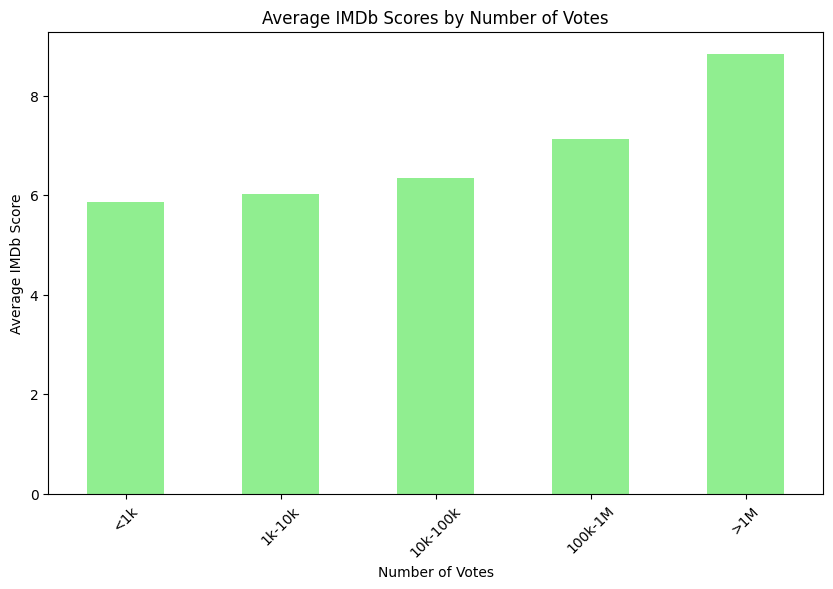

In [ ]:
# Impact of the number of votes on IMDb scores

votes = pd.read_csv(file_path)

# Create bins for the number of votes
votes['num_voted_users_bin'] = pd.cut(votes['num_voted_users'], bins=[0, 1000, 10000, 100000, 1000000, np.inf], labels=['<1k', '1k-10k', '10k-100k', '100k-1M', '>1M'])

# Calculate the average IMDb score for each bin
votes_avg_scores = votes.groupby('num_voted_users_bin')['imdb_score'].mean()

# Plot the average IMDb scores by number of votes
plt.figure(figsize=(10, 6))
votes_avg_scores.plot(kind='bar', color='lightgreen')
plt.title('Average IMDb Scores by Number of Votes')
plt.xlabel('Number of Votes')
plt.ylabel('Average IMDb Score')
plt.xticks(rotation=45)
plt.show()

<ipython-input-13-e5fa3d411d8e>:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  duration_avg_scores = duration.groupby('duration_bin')['imdb_score'].mean()


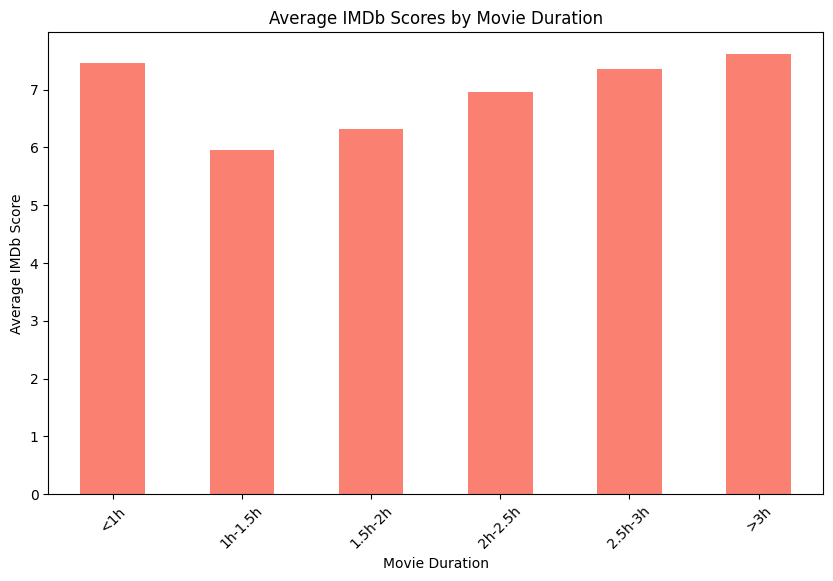

In [ ]:
# Impact of movie duration on IMDb scores

duration = pd.read_csv(file_path)

# Create bins for movie duration
duration['duration_bin'] = pd.cut(duration['duration'], bins=[0, 60, 90, 120, 150, 180, np.inf], labels=['<1h', '1h-1.5h', '1.5h-2h', '2h-2.5h', '2.5h-3h', '>3h'])

# Calculate the average IMDb score for each duration bin
duration_avg_scores = duration.groupby('duration_bin')['imdb_score'].mean()

# Plot the average IMDb scores by movie duration
plt.figure(figsize=(10, 6))
duration_avg_scores.plot(kind='bar', color='salmon')
plt.title('Average IMDb Scores by Movie Duration')
plt.xlabel('Movie Duration')
plt.ylabel('Average IMDb Score')
plt.xticks(rotation=45)
plt.show()

<ipython-input-14-f7eb3723fd4f>:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  year_avg_scores = year.groupby('title_year_bin')['imdb_score'].mean()


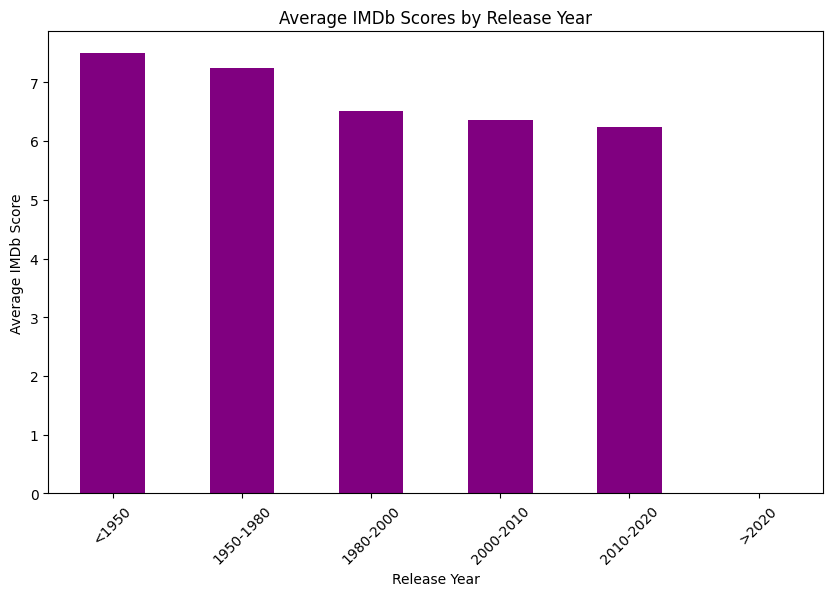

In [ ]:
# Impact of release year on IMDb scores

year = pd.read_csv(file_path)

# Create bins for release year
year['title_year_bin'] = pd.cut(year['title_year'], bins=[1910, 1950, 1980, 2000, 2010, 2020, np.inf], labels=['<1950', '1950-1980', '1980-2000', '2000-2010', '2010-2020', '>2020'])

# Calculate the average IMDb score for each release year bin
year_avg_scores = year.groupby('title_year_bin')['imdb_score'].mean()

# Plot the average IMDb scores by release year
plt.figure(figsize=(10, 6))
year_avg_scores.plot(kind='bar', color='purple')
plt.title('Average IMDb Scores by Release Year')
plt.xlabel('Release Year')
plt.ylabel('Average IMDb Score')
plt.xticks(rotation=45)
plt.show()

# Model Training and Evaluation

In [ ]:
# Model training and evaluation
def train_and_evaluate(model, name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print(f"{name} - RMSE: {rmse:.4f}, R2 Score: {r2:.4f}")

    # Visualization of predictions
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
    plt.xlabel("Actual IMDb Score")
    plt.ylabel("Predicted IMDb Score")
    plt.title(f"{name} - Actual vs Predicted IMDb Scores")
    plt.show()

    return model

Random Forest - RMSE: 0.8607, R2 Score: 0.4592


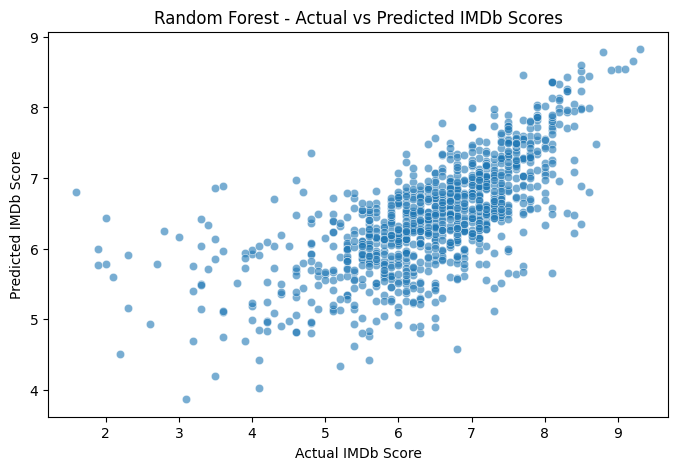

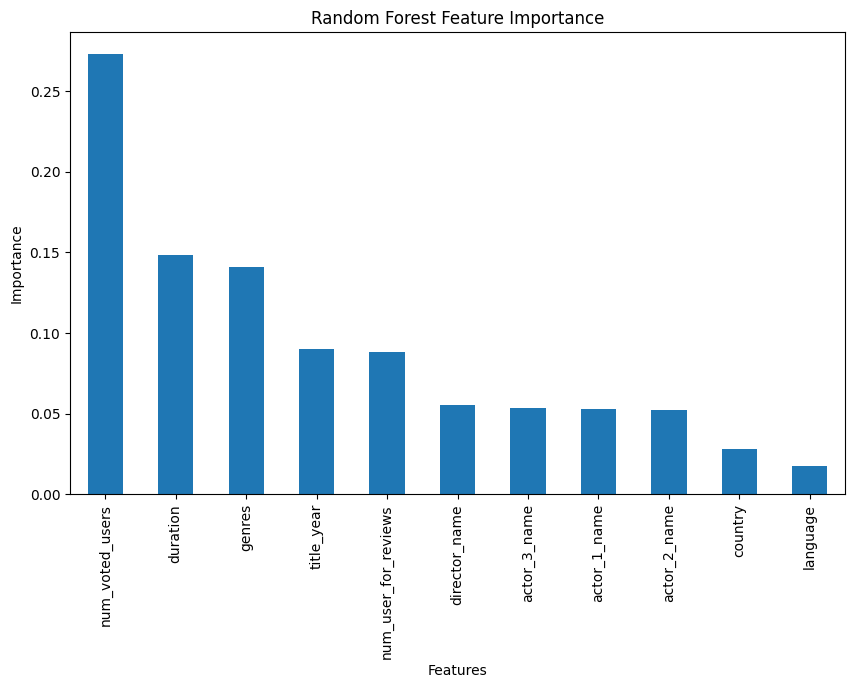

In [ ]:
# Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model = train_and_evaluate(rf_model, "Random Forest")

plt.figure(figsize=(10, 6))
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
feature_importances.sort_values(ascending=False).plot(kind='bar')
plt.title('Random Forest Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

CatBoost - RMSE: 0.8236, R2 Score: 0.5049


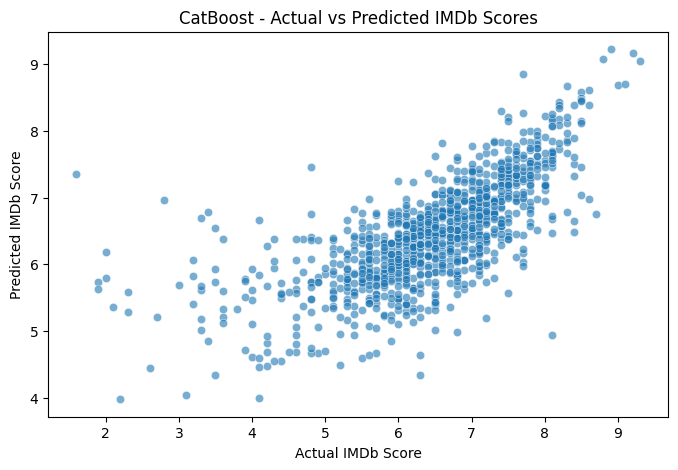

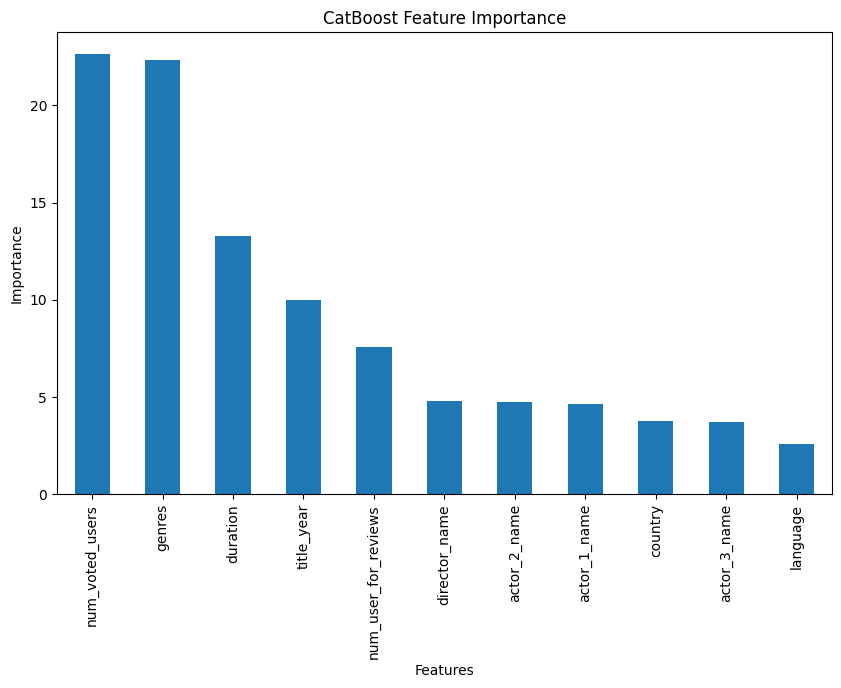

In [ ]:
# CatBoost Model
catboost_model = CatBoostRegressor(iterations=500, depth=6, learning_rate=0.1, verbose=0, random_seed=42)
catboost_model = train_and_evaluate(catboost_model, "CatBoost")

# CatBoost Feature Importance
plt.figure(figsize=(10, 6))
feature_importances = pd.Series(catboost_model.feature_importances_, index=X.columns)
feature_importances.sort_values(ascending=False).plot(kind='bar')
plt.title('CatBoost Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000783 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2037
[LightGBM] [Info] Number of data points in the train set: 4034, number of used features: 11
[LightGBM] [Info] Start training from score 6.442365
LightGBM - RMSE: 0.8440, R2 Score: 0.4799


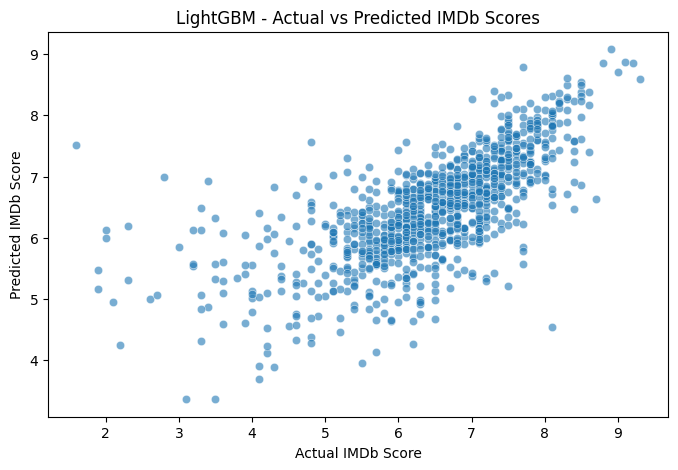

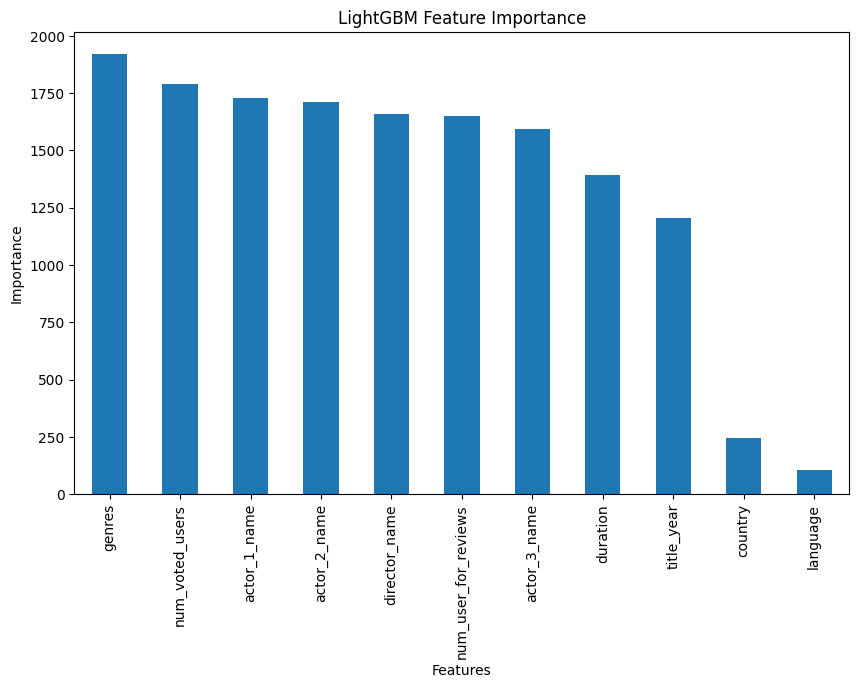

In [ ]:
# LightGBM Model
lgbm_model = LGBMRegressor(n_estimators=500, learning_rate=0.1, random_state=42)
lgbm_model = train_and_evaluate(lgbm_model, "LightGBM")

# LightGBM Feature Importance
plt.figure(figsize=(10, 6))
feature_importances = pd.Series(lgbm_model.feature_importances_, index=X.columns)
feature_importances.sort_values(ascending=False).plot(kind='bar')
plt.title('LightGBM Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

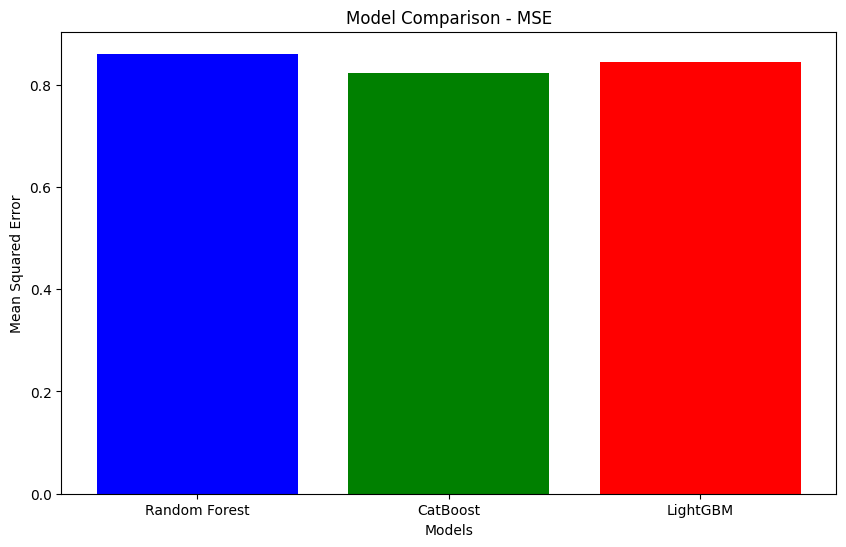

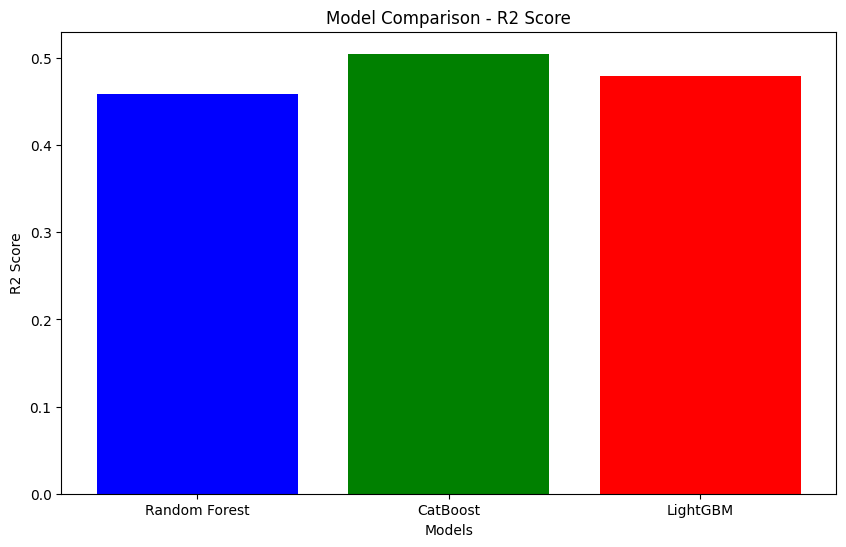

In [ ]:
# Model Comparison
models = ['Random Forest', 'CatBoost', 'LightGBM']
mse_scores = [0.8607, 0.8236, 0.8440]
r2_scores = [0.4592, 0.5049, 0.4799]

plt.figure(figsize=(10, 6))
plt.bar(models, mse_scores, color=['blue', 'green', 'red'])
plt.title('Model Comparison - MSE')
plt.xlabel('Models')
plt.ylabel('Mean Squared Error')
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(models, r2_scores, color=['blue', 'green', 'red'])
plt.title('Model Comparison - R2 Score')
plt.xlabel('Models')
plt.ylabel('R2 Score')
plt.show()

                 Feature  RandomForest   CatBoost  LightGBM
6        num_voted_users      0.272933  22.630711      1790
1               duration      0.148599  13.271951      1392
5                 genres      0.140828  22.349461      1920
10            title_year      0.090159   9.992201      1206
7   num_user_for_reviews      0.087926   7.571193      1649
0          director_name      0.055142   4.781678      1658
4           actor_3_name      0.053721   3.722040      1595
2           actor_1_name      0.052953   4.646093      1727
3           actor_2_name      0.052302   4.726719      1710
9                country      0.027990   3.749635       247
8               language      0.017446   2.558317       106


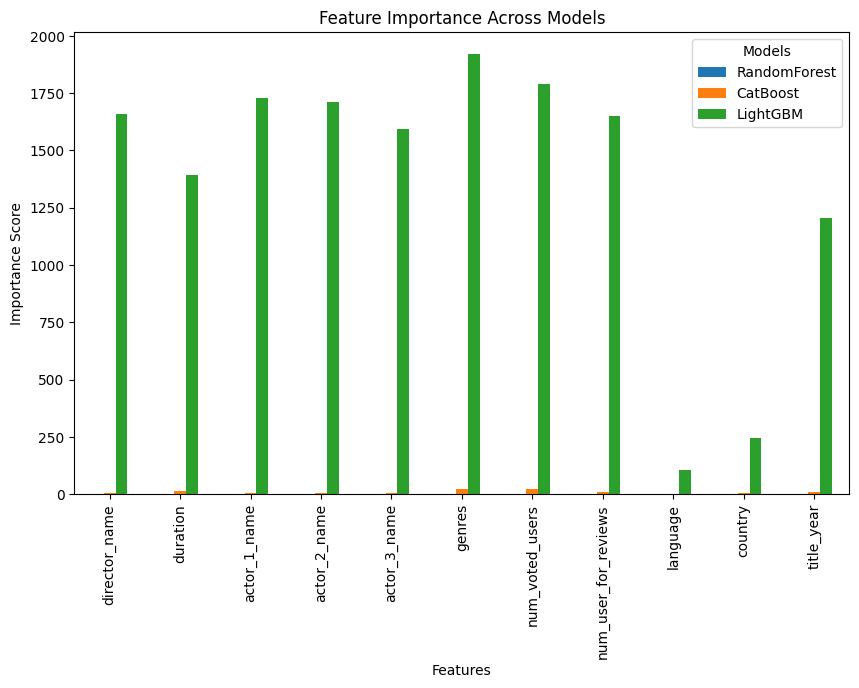

In [ ]:
# Feature importance
importances = pd.DataFrame({
    'Feature': features,
    'RandomForest': rf_model.feature_importances_,
    'CatBoost': catboost_model.feature_importances_,
    'LightGBM': lgbm_model.feature_importances_
})
print(importances.sort_values(by="RandomForest", ascending=False))

# Visualization of feature importance
importances.set_index("Feature", inplace=True)
importances.plot(kind="bar", figsize=(10, 6))
plt.title("Feature Importance Across Models")
plt.ylabel("Importance Score")
plt.xlabel("Features")
plt.legend(title="Models")
plt.show()

# IMDB Score Prediction

In [ ]:
# Define Pre-release and Post-release Feature Sets
pre_release_features = ["director_name", "actor_1_name", "actor_2_name",
                        "actor_3_name", "genres", "duration", "title_year"]
post_release_features = pre_release_features + ["num_voted_users", "num_user_for_reviews"]

df_pre = df[pre_release_features + ["imdb_score"]].dropna()
df_post = df[post_release_features + ["imdb_score"]].dropna()

# Split Data into Pre and Post training and test sets
X_pre_train, X_pre_test, y_pre_train, y_pre_test = train_test_split(df_pre.drop("imdb_score", axis=1), df_pre["imdb_score"], test_size=0.2, random_state=42)
X_post_train, X_post_test, y_post_train, y_post_test = train_test_split(df_post.drop("imdb_score", axis=1), df_post["imdb_score"], test_size=0.2, random_state=42)

# Train CatBoost Model
model = cb.CatBoostRegressor(n_estimators=200, learning_rate=0.1, depth=7, verbose=0, random_state=42)
model.fit(X_post_train, y_post_train)

# Evaluate Model
y_pred = model.predict(X_post_test)
rmse = np.sqrt(mean_squared_error(y_post_test, y_pred))
print(f"RMSE: {rmse:.4f}")

# Save Model
model.save_model("best_catboost_model.cbm")


RMSE: 0.8603


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset
df = pd.read_csv(file_path)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

class ColdStartSolutionModel:
    def __init__(self, data):
        """
        Initialize cold start solution with historical data

        :param data: Full preprocessed dataset
        """
        self.data = data
        self.prepare_cold_start_data()

    def prepare_cold_start_data(self):
        """
        Prepare aggregated historical data for cold start prediction
        """
        # Create aggregated dataframes for directors, actors, and genres
        self.director_avg = self.data.groupby('director_name')['imdb_score'].agg(['mean', 'count']).reset_index()
        self.actor_avg = self.data.groupby('actor_1_name')['imdb_score'].agg(['mean', 'count']).reset_index()
        self.genre_avg = self.data.groupby('genres')['imdb_score'].agg(['mean', 'count']).reset_index()

    def predict_for_new_movie(self, movie_info):
        """
        Predict IMDb score for a new movie with limited information

        :param movie_info: Dictionary with movie details
        :return: Predicted IMDb score and confidence interval
        """
        # Check historical averages
        director_score = self.director_avg[
            self.director_avg['director_name'] == movie_info['director_name']
        ]['mean'].values

        actor_score = self.actor_avg[
            self.actor_avg['actor_1_name'] == movie_info['actor_1_name']
        ]['mean'].values

        genre_score = self.genre_avg[
            self.genre_avg['genres'] == movie_info['genres']
        ]['mean'].values

        # Fallback to global average if no specific data
        global_avg = self.data['imdb_score'].mean()

        # Weighted average prediction
        predictions = []
        weights = []

        if len(director_score) > 0:
            predictions.append(director_score[0])
            weights.append(0.4)

        if len(actor_score) > 0:
            predictions.append(actor_score[0])
            weights.append(0.3)

        if len(genre_score) > 0:
            predictions.append(genre_score[0])
            weights.append(0.2)

        predictions.append(global_avg)
        weights.append(0.1)

        # Weighted average prediction
        predicted_score = np.average(predictions, weights=weights)

        # Confidence interval
        std_dev = self.data['imdb_score'].std()
        lower_bound = max(1, predicted_score - std_dev)
        upper_bound = min(10, predicted_score + std_dev)

        return {
            'predicted_score': predicted_score,
            'confidence_interval': (lower_bound, upper_bound),
            'prediction_details': {
                'director_score': director_score[0] if len(director_score) > 0 else None,
                'actor_score': actor_score[0] if len(actor_score) > 0 else None,
                'genre_score': genre_score[0] if len(genre_score) > 0 else None,
                'global_average': global_avg
            }
        }

# Example usage
cold_start_model = ColdStartSolutionModel(df)

# Example prediction for a new movie
new_movie = {
    'director_name': 'Christopher Nolan',
    'actor_1_name': 'Leonardo DiCaprio',
    'genres': 'Drama|Sci-Fi'
}

prediction_result = cold_start_model.predict_for_new_movie(new_movie)
print("\nNew Movie Prediction:")
print(f"Predicted IMDb Score: {prediction_result['predicted_score']:.2f}")
print(f"Confidence Interval: {prediction_result['confidence_interval']}")
print("\nPrediction Breakdown:")
for key, value in prediction_result['prediction_details'].items():
    print(f"- {key.replace('_', ' ').title()}: {value}")


New Movie Prediction:
Predicted IMDb Score: 7.71
Confidence Interval: (6.587669324488431, 8.837901055954053)

Prediction Breakdown:
- Director Score: 8.425
- Actor Score: 7.495238095238095
- Genre Score: 7.25
- Global Average: 6.442137616498116


In [ ]:
# Check if the model file exists
if not os.path.exists("best_catboost_model.cbm"):
    print("Error: Model file not found. Train the model first.")
    exit()

# Load the trained CatBoost model
best_catboost = cb.CatBoostRegressor()
best_catboost.load_model("best_catboost_model.cbm")
print("Model loaded successfully.")

# Check if label encoders exist
if not os.path.exists("label_encoders.pkl"):
    print("Error: Label encoders file not found. Train the model first.")
    exit()

# Load label encoders
with open("label_encoders.pkl", "rb") as f:
    label_encoders = pickle.load(f)
print("Label encoders loaded successfully.")

def get_movie_details():
    print("\nPredict the IMDb rating for a movie.\n")

    # Get user inputs
    director_name = input("Enter the director's name: ").strip()
    actor_1_name = input("Enter the first lead actor's name: ").strip()
    actor_2_name = input("Enter the second lead actor's name: ").strip()
    actor_3_name = input("Enter the third lead actor's name: ").strip()
    genres = input("Enter the genre (e.g., Action, Comedy, Drama): ").strip()
    duration = int(input("Enter the movie duration (in minutes): ").strip())
    title_year = int(input("Enter the release year: ").strip())

    # Ask if the movie has been released
    is_released = input("Has the movie been released? (yes/no): ").strip().lower()

    if is_released == "yes":
        # Automatically remove commas before converting to an integer
        num_voted_users = int(input("Enter the number of votes received: ").replace(",", "").strip())
        num_user_for_reviews = int(input("Enter the number of user reviews received: ").replace(",", "").strip())
    else:
        num_voted_users = 0
        num_user_for_reviews = 0


    def encode_feature(value, feature_name):
        if feature_name in label_encoders and value in label_encoders[feature_name].classes_:
            return label_encoders[feature_name].transform([value])[0]
        else:
            return 0

    # Encode categorical features
    director_encoded = encode_feature(director_name, "director_name")
    actor_1_encoded = encode_feature(actor_1_name, "actor_1_name")
    actor_2_encoded = encode_feature(actor_2_name, "actor_2_name")
    actor_3_encoded = encode_feature(actor_3_name, "actor_3_name")
    genre_encoded = encode_feature(genres, "genres")

    # Create input dataframe
    movie_data = pd.DataFrame({
        "director_name": [director_encoded],
        "actor_1_name": [actor_1_encoded],
        "actor_2_name": [actor_2_encoded],
        "actor_3_name": [actor_3_encoded],
        "genres": [genre_encoded],
        "duration": [duration],
        "title_year": [title_year],
        "num_voted_users": [num_voted_users],
        "num_user_for_reviews": [num_user_for_reviews]
    })

    # Predict IMDb rating
    predicted_rating = best_catboost.predict(movie_data)
    print(f"\nPredicted IMDb Rating: {predicted_rating[0]:.2f}\n")

# Run the interactive function
get_movie_details()

Model loaded successfully.
Label encoders loaded successfully.

Predict the IMDb rating for a movie.

Enter the director's name: Jared Hess
Enter the first lead actor's name: Jennifer Coolidge
Enter the second lead actor's name: Jason Momoa
Enter the third lead actor's name: Emma Myers
Enter the genre (e.g., Action, Comedy, Drama): Comedy
Enter the movie duration (in minutes): 100
Enter the release year: 2025
Has the movie been released? (yes/no): no

Predicted IMDb Rating: 6.72

